# 임베딩을 사용한 감성 프로그래밍

## 텐서플로의 임베딩
-  자연어 처리에서 사람이 쓰는 자연어를 기계가 이해할 수 있도록 숫자형태인 vector로 바꾸는 과정 혹은 일련의 전체 과정을 의미합니다. 
- 단어나 문장 각각을 벡터로 변환해 벡터 공간(Vector space)으로 끼워넣는다는 의미에서 임베딩이라 합니다.

In [1]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !wget -q https://github.com/rickiepark/aiml4coders/raw/main/ch05/sarcasm.json
    !mkdir ../ch05
    !mv sarcasm.json ../ch05


In [3]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf

In [4]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [5]:
with open("../ch05/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [6]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [7]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
# 임베딩을 사용해 빈정거림 감지기 만들기

import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [11]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

In [ ]:
# 임베딩 층은 초기에 랜덤하게 초기화
# 초기화된 상태에ㅔ서 역전파를 사용해 학습
tf.keras.layers.Embedding(vocab_size, embedding_dim)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16), # 어휘 사전 크기 10000, 임베딩 차원 16
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [15]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 6s 7ms/step - loss: 0.6789 - accuracy: 0.5648 - val_loss: 0.6487 - val_accuracy: 0.6341
Epoch 2/30
719/719 [==============================] - 5s 7ms/step - loss: 0.5409 - accuracy: 0.7452 - val_loss: 0.4785 - val_accuracy: 0.7754
Epoch 3/30
719/719 [==============================] - 4s 6ms/step - loss: 0.3884 - accuracy: 0.8328 - val_loss: 0.4267 - val_accuracy: 0.8005
Epoch 4/30
719/719 [==============================] - 4s 6ms/step - loss: 0.3259 - accuracy: 0.8615 - val_loss: 0.4184 - val_accuracy: 0.8086
Epoch 5/30
719/719 [==============================] - 9s 12ms/step - loss: 0.2865 - accuracy: 0.8816 - val_loss: 0.4222 - val_accuracy: 0.8080
Epoch 6/30
719/719 [==============================] - 8s 12ms/step - loss: 0.2600 - accuracy: 0.8943 - val_loss: 0.4371 - val_accuracy: 0.8040
Epoch 7/30
719/719 [==============================] - 8s 11ms/step - loss: 0.2396 - accuracy: 0.9020 - val_loss: 0.4459 - val_accuracy: 0.8056
Epo

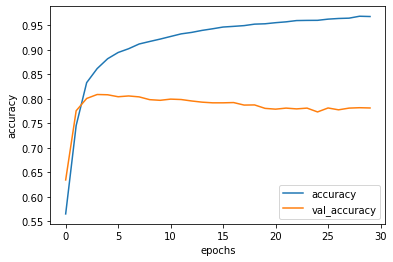

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

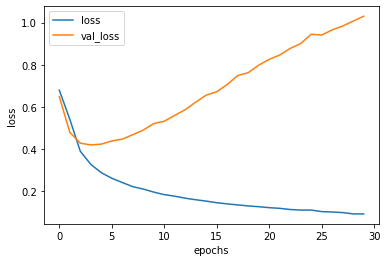

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## 언어 모델의 과대 적합 줄이기
- 검증 데이터에는 없는 훈련 데이터로 인하여 학습 횟수가 증가함에 따라
- 언어의 예측 불가능한 성질로 인해 과대적합 현상이 자연어 처리 모델에서 흔히 발생

#### 학습률 조정하기

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001,
                                beta_1=0.9, beta=0.999, amsgrad=False)
# amsgrad는 On the Convergence of Adam and Beyond 논문에 나온 또 다른 Adam의 구현
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(training_padded, training_labels, epochs=60,
                    validation_data=(testing_padded, testing_labels))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 어휘 사전 크기 바꾸기

In [ ]:
wc = tokenizer.word_counts
print(wc)

In [ ]:
from collections import OrderedDict
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
print(newlist)

In [ ]:
xs = []
ys = []
curr_x = 1
for item in newlist:
  xs.append(curr_x)
  curr_x = curr_x + 1
  ys.append(newlist[item])

plt.plot(xs, ys)
plt.show()

In [ ]:
plt.plot(xs,ys)
plt.axis([300,10000,0,100])
plt.show()

In [22]:
vocab_size = 2000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [23]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [25]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 6s 7ms/step - loss: 0.6712 - accuracy: 0.5804 - val_loss: 0.6162 - val_accuracy: 0.6576
Epoch 2/30
719/719 [==============================] - 3s 4ms/step - loss: 0.5311 - accuracy: 0.7380 - val_loss: 0.4982 - val_accuracy: 0.7528
Epoch 3/30
719/719 [==============================] - 3s 5ms/step - loss: 0.4500 - accuracy: 0.7830 - val_loss: 0.4663 - val_accuracy: 0.7706
Epoch 4/30
719/719 [==============================] - 4s 5ms/step - loss: 0.4244 - accuracy: 0.7979 - val_loss: 0.4690 - val_accuracy: 0.7668
Epoch 5/30
719/719 [==============================] - 2s 3ms/step - loss: 0.4169 - accuracy: 0.8007 - val_loss: 0.4606 - val_accuracy: 0.7813
Epoch 6/30
719/719 [==============================] - 2s 3ms/step - loss: 0.4083 - accuracy: 0.8023 - val_loss: 0.4612 - val_accuracy: 0.7760
Epoch 7/30
719/719 [==============================] - 4s 5ms/step - loss: 0.4020 - accuracy: 0.8077 - val_loss: 0.4631 - val_accuracy: 0.7805
Epoch 

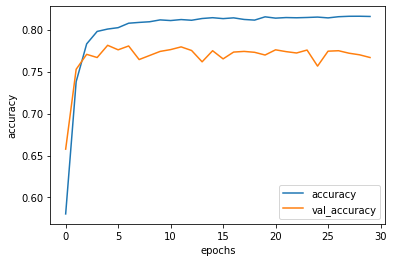

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

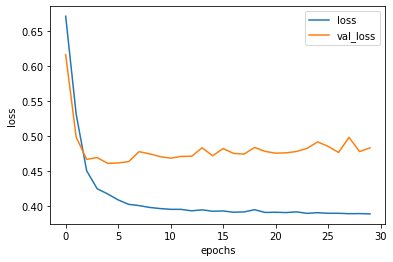

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 임베딩 차원 바꾸기
- 예제에서는 임의로 임베딩 차원 16을 선택
- 단어가 적을 경우 벡터의 일부 원소가 비어있거나 작을 수 있습니다.
- 임베딩 크기를 결정하는 모범 사례는 어희 사전의 네제곱근을 사용하는 것
- https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html 참고

In [ ]:
embedding_dim = 7

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [29]:
num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/50
719/719 [==============================] - 4s 3ms/step - loss: 0.6835 - accuracy: 0.5590 - val_loss: 0.6710 - val_accuracy: 0.5821
Epoch 2/50
719/719 [==============================] - 3s 4ms/step - loss: 0.6025 - accuracy: 0.6734 - val_loss: 0.5347 - val_accuracy: 0.7369
Epoch 3/50
719/719 [==============================] - 2s 3ms/step - loss: 0.4840 - accuracy: 0.7660 - val_loss: 0.4778 - val_accuracy: 0.7646
Epoch 4/50
719/719 [==============================] - 4s 5ms/step - loss: 0.4408 - accuracy: 0.7894 - val_loss: 0.4654 - val_accuracy: 0.7716
Epoch 5/50
719/719 [==============================] - 4s 5ms/step - loss: 0.4231 - accuracy: 0.7977 - val_loss: 0.4617 - val_accuracy: 0.7765
Epoch 6/50
719/719 [==============================] - 3s 4ms/step - loss: 0.4143 - accuracy: 0.8014 - val_loss: 0.4627 - val_accuracy: 0.7722
Epoch 7/50
719/719 [==============================] - 2s 3ms/step - loss: 0.4072 - accuracy: 0.8053 - val_loss: 0.4709 - val_accuracy: 0.7671
Epoch 

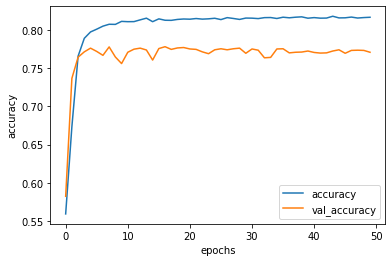

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

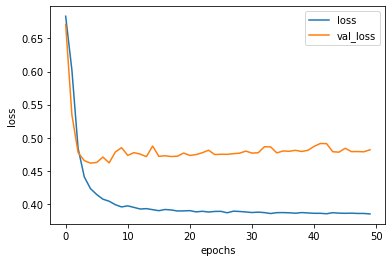

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          32000     
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 24)                408       
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 32,433
Trainable params: 32,433
Non-trainable params: 0
_________________________________________________________________


#### 모델 구조 변경하기 & 드롭아웃 사용하기

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 7),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 7)           14000     
                                                                 
 global_average_pooling1d_3   (None, 7)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 8)                 64        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 14,073
Trainable params: 14,073
Non-trainable params: 0
__________________________________________________

In [34]:
num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=50,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/50
719/719 [==============================] - 4s 4ms/step - loss: 0.6852 - accuracy: 0.5569 - val_loss: 0.6758 - val_accuracy: 0.5700
Epoch 2/50
719/719 [==============================] - 3s 4ms/step - loss: 0.6459 - accuracy: 0.6308 - val_loss: 0.5974 - val_accuracy: 0.7021
Epoch 3/50
719/719 [==============================] - 3s 4ms/step - loss: 0.5616 - accuracy: 0.7230 - val_loss: 0.5236 - val_accuracy: 0.7522
Epoch 4/50
719/719 [==============================] - 2s 3ms/step - loss: 0.5033 - accuracy: 0.7595 - val_loss: 0.4937 - val_accuracy: 0.7571
Epoch 5/50
719/719 [==============================] - 2s 3ms/step - loss: 0.4720 - accuracy: 0.7782 - val_loss: 0.4764 - val_accuracy: 0.7617
Epoch 6/50
719/719 [==============================] - 2s 3ms/step - loss: 0.4584 - accuracy: 0.7843 - val_loss: 0.4673 - val_accuracy: 0.7738
Epoch 7/50
719/719 [==============================] - 2s 3ms/step - loss: 0.4436 - accuracy: 0.7938 - val_loss: 0.4642 - val_accuracy: 0.7765
Epoch 

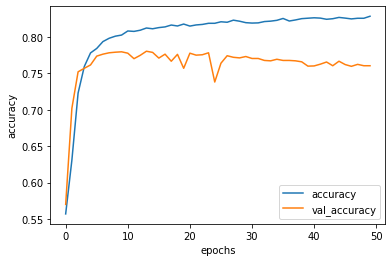

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

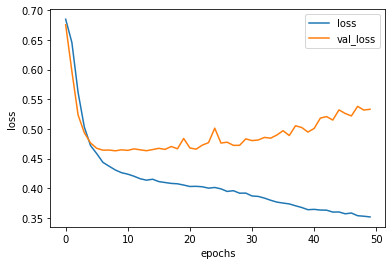

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

- 학습이 진행됨에 따라 검증 손실이 더 많이 발생
- 매우 적은 뉴런을 사용할 때는 드롭아웃이 좋은 방법이 아닐 수도 있다는 것을 명심

#### 규제 사용하기
- 규제는 가중치의 크기를 감소시켜 과대적합을 방지하는 기법
- L1 규제 (라쏘) : 층의 가중치를 0 또는 0에 가까운 값으로 만든다
- L2 규제 (리지) : 0에서 먼 값과 0에 가까운 값의 차이를 증폭시켜 가중치가 강하게 규제된다.
- 두 방식을 모두 사용하는 방식은 일래스틱넷 규제라고 한다.
- 자연어 처리에서는 주로 L2 규제 사용

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [ ]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

- 이런 간단한 모델에서의 규제 효과는 크지 않습니다.
- 하지만 훈련 손실과 검증 손실 곡선이 조금 부드러워지는 효과가 있었습니다.

#### 다른 고려 사항
- 문장 길이와 같은 다른 하이퍼 파라미터를 통해 최적화를 시킬 수도 있습니다.

In [ ]:
xs=[]
ys=[]
current_item=1
for item in sentences:
    xs.append(current_item)
    current_item=current_item+1
    ys.append(len(item))
newys = sorted(ys)

plt.plot(xs,newys)
plt.show()

- 26000개 중 단어 100개 이상의 문장은 200개 미만
- 따라서 이 길이를 최대 길이로 하면 불필요한 패딩이 늘어나 모델 성능에 영향을 미칩니다

## 모델을 사용해 문장 분류하기

In [ ]:
sentences = ["granny starting to fear spiders in the garden might be real", 
             "game of thrones season finale showing this sunday night", 
             "TensorFlow book will be a best seller"]

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

In [ ]:
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, truncating=trunc_type)
print(padded)

In [ ]:
print(model.predict(padded))

## 임베딩 시각화

In [ ]:
# 인덱스와 키 값 반대로 매핑
reverse_word_index = dict([(value, key)
for (key, value) in word_index.items()])

In [ ]:
# 임베딩 층의 가중치 추출
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

In [ ]:
print(tokenizer.index_word[2])
print(weights[2])

In [ ]:
# 임베딩 프로젝터는 탭으로 구분된 두 개의 TSV파일 사용
# 벡터 저장하는 파일과 메타데이터 저장 파일
# 생성 코드
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = tokenizer.index_word[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()